# Level 1: Rice Crop Discovery Tool Benchmark Notebook

## Challenge Level 1 Overview

<p align="justify">Welcome to the EY Open Science Data Challenge 2023! This challenge consists of two levels – Level 1 and Level 2. This is the Level 1 challenge aimed at participants who are beginners or have intermediate skill sets in data science and programming. The goal of Level 1 is to predict the presence of rice crops at a given location using satellite data. By the time you complete this level, you will have developed a rice crop classification model, which can distinguish between rice and non-rice fields. 
</p>

<b>Challenge Aim: </b><p align="justify"> <p>

<p align="justify">In this notebook, we will demonstrate a basic model workflow that can serve as a starting point for the challenge. The basic model has been built to predict rice crops against non-rice crops (which might include forest, other vegetation and water bodies) using features from the Sentinel-1 Radiometrically Terrain Corrected (RTC)  dataset as predictor variables. In this demonstration, we have used two features from the Sentinel-1 dataset, namely VV (Vertical polarization – Vertical polarization) and VH (Vertical polarization – Horizontal polarization) and trained a logistic regression model with these features. We have extracted the VV band and VH band data from the Sentinel-1 dataset for one day (21st March 2020), with an assumption that VV and VH values for this day are representative of VV and VH values for the entire year (2020) for a given location.

Most of the functions presented in this notebook were adapted from the <a href="https://planetarycomputer.microsoft.com/dataset/sentinel-1-rtc#Example-Notebook">Sentinel-1-RTC notebook</a> found in the Planetary Computer portal.</p>
    
<p align="justify"> Please note that this notebook is just a starting point. We have made many assumptions in this notebook that you may think are not best for solving the challenge effectively. You are encouraged to modify these functions, rewrite them, or try an entirely new approach.</p>

## Load In Dependencies

To run this demonstration notebook, you will need to have the following packages imported below installed. This may take some time.  

#### Note: Environment setup
Running this notebook requires an API key.

To use your API key locally, set the environment variable <i><b>PC_SDK_SUBSCRIPTION_KEY</i></b> or use <i><b>pc.settings.set_subscription_key(<YOUR API Key>)</i></b><br>
See <a href="https://planetarycomputer.microsoft.com/docs/concepts/sas/#when-an-account-is-needed">when an account is needed for more </a>, and <a href="https://planetarycomputer.microsoft.com/account/request">request</a> an account if needed.

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('975fedf10857472a9ff1cff2b3420ba8')

# Others
import requests
import rich.table
from itertools import cycle
from tqdm import tqdm
tqdm.pandas()

## Response Variable

Before building the model, we need to load in the rice crop presence data. We have curated for you data from a certain region in Vietnam for the year 2020. The data consists of  geo locations (Latitude and Longitude) with a tag specifying if the crop present in each geo location is rice or not.  

In [2]:
crop_presence_data = pd.read_csv("Crop_Location_Data_20221201.csv")
crop_presence_data.head()

,Latitude and Longitude,Class of Land
0,"(10.323727047081501, 105.2516346045924)",Rice
1,"(10.322364360592521, 105.27843410554115)",Rice
2,"(10.321455902933202, 105.25254306225168)",Rice
3,"(10.324181275911162, 105.25118037576274)",Rice
4,"(10.324635504740822, 105.27389181724476)",Rice


## Predictor Variables

<p align ="justify">Now that we have our crop location data, it is time to gather the predictor variables from the Sentinel-1 dataset. For a more in-depth look regarding the Sentinel-1 dataset and how to query it, see the Sentinel-1 <a href="https://challenge.ey.com/api/v1/storage/admin-files/6403146221623637-63ca8d537b1fe300146c79d0-Sentinel%201%20Phenology.ipynb/"> supplementary 
notebook</a>.
    

<p align = "justify">Sentinel-1 radar data penetrates through the clouds, thus helping us to get the band values with minimal atmospheric attenuation. Band values such as VV and VH help us in distinguishing between the rice and non rice crops. Hence we are choosing VV and VH as predictor variables for this experiment. 
        
<ul>
<li>VV - gamma naught values of signal transmitted with vertical polarization and received with vertical polarization with radiometric terrain correction applied.

<li>VH - gamma naught values of signal transmitted with vertical polarization and received with horizontal polarization with radiometric terrain correction applied.
</ul>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 1</strong></h4>
<p align="justify">Participants might explore other combinations of bands from the Sentinel-1 data. For example, you can use mathematical combinations of bands to generate various <a href="https://challenge.ey.com/api/v1/storage/admin-files/3868217534768359-63ca8dc8aea56e00146e3489-Comprehensive%20Guide%20-%20Satellite%20Data.docx">vegetation indices </a> which can then be used as features in your model.


### Accessing the Sentinel-1 Data

<p align = "Justify">To get the Sentinel-1 data, we write a function called <i><b>get_sentinel_data.</b></i> This function will fetch VV and VH band values for a particular location over the specified time window. In this example, we have extracted VV and VH values for a day (21st March 2020). </p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 2</strong></h4>
<p align="justify"> Extract VV and VH band values for an entire year. Different land classes (e.g., agriculture, water, urban) will have different annual variability. This variability will be better than a single date for accurately identifying land classes. Please find below a demonstration of extracting data for a day (21st March 2020).

In [3]:
def get_sentinel_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''

    latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    #bbox_of_interest = (float(latlong[1]) , float(latlong[0]), float(latlong[1]) , float(latlong[0]))
    lat_long = (10.4391, 105.3338) # Lat-Lon centroid location
    box_size_deg = 0.0004 # Surrounding box in degrees, yields approximately 5x5 pixel region

    min_lon = float(latlong[1])-box_size_deg/2
    min_lat = float(latlong[0])-box_size_deg/2
    max_lon = float(latlong[1])+box_size_deg/2
    max_lat = float(latlong[0])+box_size_deg/2

    bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)
    time_of_interest = time_slice

    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1"
    )
    search = catalog.search(
        collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest
    )
    items = list(search.get_all_items())
    bands_of_interest = assests
    data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
    vh = data["vh"].astype("float").values.tolist()[0][0]
    vv = data["vv"].astype("float").values.tolist()[0][0]
    return vh,vv

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 3 </strong></h4>

Explore the approach of building a bounding box (e.g., 5x5 pixels) around the given latitude and longitude positions and then extract the aggregated band values (e.g., average, median) to get normalized band values to build the model. Radar data has inherent variability at the pixel level due to variable scattering response from the target. This effect is called “speckle” and it is common to filter the data to smooth these variations. Try using a 3x3, 5x5 or 7x7 window around the specific latitude and longitude point to get improved results.

In [4]:
## Function call to extract VV,VH Values
time_slice = "2020-03-20/2021-03-21"
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice,assests))
vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv'])

100%|██████████| 600/600 [03:18<00:00,  3.03it/s]


## Joining the predictor variables and response variables
Now that we have extracted our predictor variables, we need to join them onto the response variable . We use the function <i><b>combine_two_datasets</b></i> to combine the predictor variables and response variables.The <i><b>concat</b></i> function from pandas comes in handy here.

In [5]:
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [6]:
crop_data = combine_two_datasets(crop_presence_data,vh_vv_data)
crop_data.head()

,Latitude and Longitude,Class of Land,vh,vv
0,"(10.323727047081501, 105.2516346045924)",Rice,0.028296,0.112560
1,"(10.322364360592521, 105.27843410554115)",Rice,0.051894,0.048721
2,"(10.321455902933202, 105.25254306225168)",Rice,0.020894,0.042157
3,"(10.324181275911162, 105.25118037576274)",Rice,0.013615,0.066477
4,"(10.324635504740822, 105.27389181724476)",Rice,0.012968,0.015349


## Model Building


<p align="justify"> Now let us select the columns required for our model building exercise. We will consider only VV and VH for our model. It does not make sense to use latitude and longitude as predictor variables as they do not have any impact on presence of rice crop.</p>

In [7]:
crop_data = crop_data[['vh','vv','Class of Land']]

### Train and Test Split 

<p align="justify">We will now split the data into 70% training data and 30% test data. Scikit-learn alias “sklearn” is a robust library for machine learning in Python. The scikit-learn library has a <i><b>model_selection</b></i> module in which there is a splitting function <i><b>train_test_split</b></i>. You can use the same.</p>

In [8]:
X = crop_data.drop(columns=['Class of Land']).values
y = crop_data ['Class of Land'].values
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=40)

# Split train+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=40) # 0.25 x 0.8 = 0.2

### Feature Scaling 

<p align="justify"> Before initiating the model training we may have to execute different data pre-processing steps. Here we are demonstrating the scaling of VV and VH variable by using Standard Scaler.</p>

<p align = "justify">Feature Scaling is a data preprocessing step for numerical features. Many machine learning algorithms like Gradient descent methods, KNN algorithm, linear and logistic regression, etc. require data scaling to produce good results. Scikit learn provides functions that can be used to apply data scaling. Here we are using Standard Scaler.</p>

<h4 style="color:rgb(195, 52, 235)"><strong>Tip 4 </strong></h4>
<p align="justify">Participants might explore other feature scaling techniques like Min Max Scaler, Max Absolute Scaling, Robust Scaling etc.</p>

In [9]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [11]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'RandomForest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'SVM': SVC(C=1),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [12]:
cv_results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_val, y_val, cv=5, scoring='accuracy')
    cv_results[name] = {
        'Mean CV Accuracy': cv_scores.mean(),
        'CV Accuracy Std': cv_scores.std(),
    }
    print(f"{name}: Mean CV Accuracy: {cv_scores.mean():.2f}% (+/- {cv_scores.std() * 2:.2f}%)")

LogisticRegression: Mean CV Accuracy: 0.50% (+/- 0.00%)
DecisionTree: Mean CV Accuracy: 0.78% (+/- 0.25%)
RandomForest: Mean CV Accuracy: 0.73% (+/- 0.26%)
SVM: Mean CV Accuracy: 0.71% (+/- 0.14%)
KNN: Mean CV Accuracy: 0.77% (+/- 0.16%)
GradientBoosting: Mean CV Accuracy: 0.74% (+/- 0.25%)


In [13]:
param_grids = {
    'DecisionTree': {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

In [14]:
def hyperparameter_tuning(X_train, y_train, model, params):
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

In [15]:
best_estimators = {}
for name in ['DecisionTree', 'KNN', 'GradientBoosting', 'RandomForest']:
    print(f"Tuning hyperparameters for {name}...")
    model = models[name]
    params = param_grids[name]
    best_estimator, best_params, best_score = hyperparameter_tuning(X_train, y_train, model, params)
    best_estimators[name] = best_estimator
    print(f"Best parameters for {name}: {best_params}")
    print(f"Best cross-validation accuracy for {name}: {best_score:.2f}%")

Tuning hyperparameters for DecisionTree...
Best parameters for DecisionTree: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation accuracy for DecisionTree: 0.80%
Tuning hyperparameters for KNN...
Best parameters for KNN: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}
Best cross-validation accuracy for KNN: 0.79%
Tuning hyperparameters for GradientBoosting...
Best parameters for GradientBoosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best cross-validation accuracy for GradientBoosting: 0.80%
Tuning hyperparameters for RandomForest...
Best parameters for RandomForest: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation accuracy for RandomForest: 0.80%


### Model Training

<p justify ="align">Now that we have the data in a format appropriate for machine learning, we can begin training a model. In this demonstration notebook, we have used a binary logistic regression model from the scikit-learn library. This library offers a wide range of other models, each with the capacity for extensive parameter tuning and customization capabilities.</p>

<p justify ="align">Scikit-learn models require separation of predictor variables and the response variable. You have to store the predictor variables in array X and the response variable in the array Y. You must make sure not to include the response variable in array X. It also doesn't make sense to use latitude and longitude as predictor variables in such a confined area, so we drop those too.</p>

In [11]:
def model_evaluation(X_train, y_train, X_val, y_val):
    models = {
        'LogisticRegression': LogisticRegression(),
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'SVM': SVC(),
        'KNN': KNeighborsClassifier(),
        'GradientBoosting': GradientBoostingClassifier()
    }
    
    params = {
        'LogisticRegression': {'solver': ['lbfgs'], 'C': [1.0, 0.5, 0.1]},
        'DecisionTree': {'max_depth': [None, 10, 20, 30]},
        'RandomForest': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30]},
        'SVM': {'C': [1, 0.1, 0.01], 'kernel': ['rbf', 'linear']},
        'KNN': {'n_neighbors': [3, 5, 7, 9]},
        'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05, 0.01]}
    }
    
    best_estimators = {}
    for name, model in models.items():
        clf = GridSearchCV(model, params[name], cv=5, scoring='accuracy')
        clf.fit(X_train, y_train)
        best_estimators[name] = clf.best_estimator_
        print(f"{name} best parameters: {clf.best_params_}")
        print(f"{name} best score: {clf.best_score_:.2f}%")
        
        # Evaluate on the validation set
        y_pred_val = clf.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_pred_val)
        print(f"{name} Validation Set Accuracy: {val_accuracy:.2f}%")

    return best_estimators

In [12]:
best_estimators = model_evaluation(X_train, y_train, X_test, y_test)

LogisticRegression best parameters: {'C': 1.0, 'solver': 'lbfgs'}
LogisticRegression best score: 0.51%
LogisticRegression Validation Set Accuracy: 0.50%
DecisionTree best parameters: {'max_depth': None}
DecisionTree best score: 0.76%
DecisionTree Validation Set Accuracy: 0.72%
RandomForest best parameters: {'max_depth': None, 'n_estimators': 50}
RandomForest best score: 0.79%
RandomForest Validation Set Accuracy: 0.83%
SVM best parameters: {'C': 1, 'kernel': 'rbf'}
SVM best score: 0.51%
SVM Validation Set Accuracy: 0.50%
KNN best parameters: {'n_neighbors': 9}
KNN best score: 0.79%
KNN Validation Set Accuracy: 0.84%
GradientBoosting best parameters: {'learning_rate': 0.01, 'n_estimators': 100}
GradientBoosting best score: 0.79%
GradientBoosting Validation Set Accuracy: 0.85%


In [16]:
best_model = best_estimators['KNN'] 

In [17]:
best_model1 = best_estimators['DecisionTree'] 

In [18]:
best_model2 = best_estimators['RandomForest']

In [19]:
best_model3 = best_estimators['GradientBoosting']

## Model Evaluation

Now that we have trained our model , all that is left is to evaluate it. For evaluation we will generate the classification report and will plot the confusion matrix. Scikit-learn provides many other metrics that can be used for evaluation. You can even write a code on your own.

### In-Sample Evaluation
<p align="Jutisfy"> We will be generating a classification report and a confusion matrix for the training data. It must be stressed that this is in-sample performance testing , which is the performance testing on the training dataset. These metrics are NOT truly indicative of the model's performance. You should wait to test the model performance on the test data before you feel confident about your model.</p>

In this section, we make predictions on the training set and store them in the <b><i>insample_ predictions</i></b> variable. A confusion matrix is generated to gauge the robustness of the model. 

In [20]:
insample_predictions = best_model.predict(X_train)

In [21]:
insample_predictions1 = best_model1.predict(X_train)

In [22]:
insample_predictions2 = best_model2.predict(X_train)

In [23]:
insample_predictions3 = best_model3.predict(X_train)

In [24]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions,y_train)))
print(classification_report(insample_predictions,y_train))

Insample Accuracy 80.83%
              precision    recall  f1-score   support

    Non Rice       0.83      0.79      0.81       189
        Rice       0.78      0.82      0.80       171

    accuracy                           0.81       360
   macro avg       0.81      0.81      0.81       360
weighted avg       0.81      0.81      0.81       360



In [25]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions1,y_train)))
print(classification_report(insample_predictions1,y_train))

Insample Accuracy 83.06%
              precision    recall  f1-score   support

    Non Rice       0.79      0.86      0.82       165
        Rice       0.87      0.81      0.84       195

    accuracy                           0.83       360
   macro avg       0.83      0.83      0.83       360
weighted avg       0.83      0.83      0.83       360



In [26]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions2,y_train)))
print(classification_report(insample_predictions2,y_train))

Insample Accuracy 83.61%
              precision    recall  f1-score   support

    Non Rice       0.81      0.86      0.83       169
        Rice       0.87      0.82      0.84       191

    accuracy                           0.84       360
   macro avg       0.84      0.84      0.84       360
weighted avg       0.84      0.84      0.84       360



In [27]:
print("Insample Accuracy {0:.2f}%".format(100*accuracy_score(insample_predictions3,y_train)))
print(classification_report(insample_predictions3,y_train))

Insample Accuracy 84.44%
              precision    recall  f1-score   support

    Non Rice       0.82      0.86      0.84       172
        Rice       0.87      0.83      0.85       188

    accuracy                           0.84       360
   macro avg       0.84      0.85      0.84       360
weighted avg       0.85      0.84      0.84       360



<p> For plotting a confusion matrix we define the function <b><i>plot_confusion_matrix</i></b>.

In [30]:
def plot_confusion_matrix(true_value,predicted_value,title,labels):
    '''
    Plots a confusion matrix.
    Attributes:
    true_value - The ground truth value for comparision.
    predicted_value - The values predicted by the model.
    title - Title of the plot.
    labels - The x and y labels of the plot.
    '''
    cm = confusion_matrix(true_value,predicted_value)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues');
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title(title); 
    ax.xaxis.set_ticklabels(labels); 
    ax.yaxis.set_ticklabels(labels);

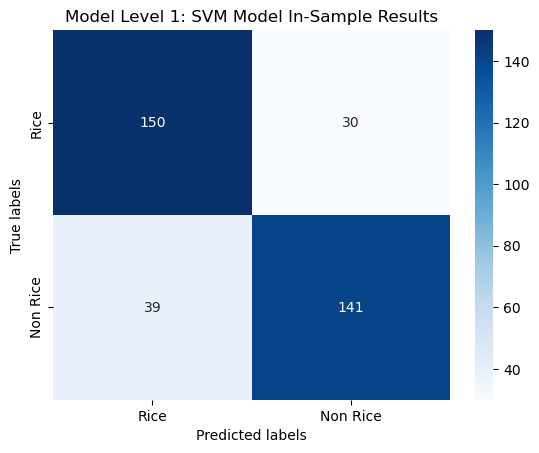

In [31]:
plot_confusion_matrix(y_train,insample_predictions,"Model Level 1: SVM Model In-Sample Results",['Rice', 'Non Rice'])

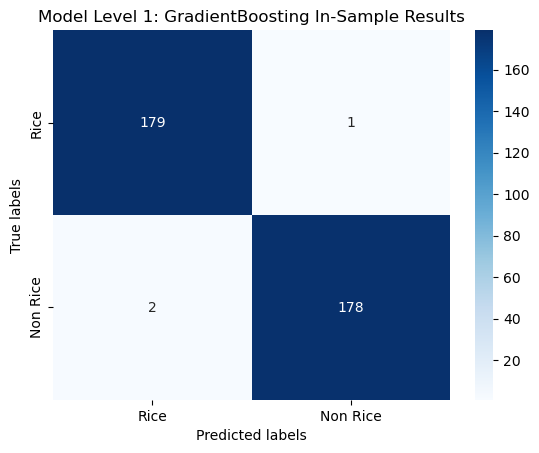

In [32]:
plot_confusion_matrix(y_train,insample_predictions1,"Model Level 1: GradientBoosting In-Sample Results",['Rice', 'Non Rice'])

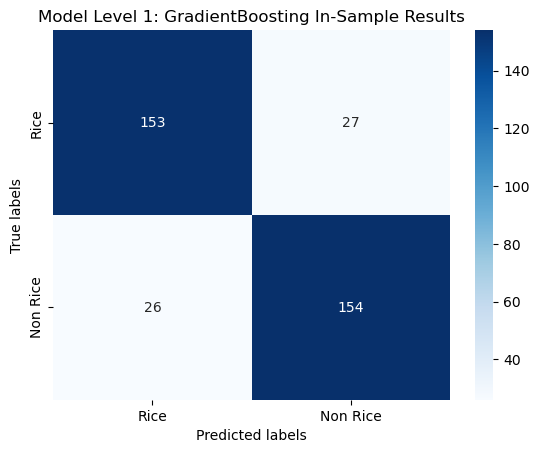

In [33]:
plot_confusion_matrix(y_train,insample_predictions2,"Model Level 1: GradientBoosting In-Sample Results",['Rice', 'Non Rice'])

### Out-Sample Evaluation

When evaluating a machine learning model, it is essential to correctly and fairly evaluate the model's ability to generalize. This is because models have a tendency to overfit the dataset they are trained on. To estimate the out-of-sample performance, we will predict on the test data now. 

In [28]:
outsample_predictions = best_model.predict(X_test)

In [29]:
outsample_predictions1 = best_model1.predict(X_test)

In [30]:
outsample_predictions2 = best_model2.predict(X_test)

In [31]:
outsample_predictions3 = best_model3.predict(X_test)

In [32]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions, y_test)))
print(classification_report(y_test, outsample_predictions))

Accuracy 84.17%
              precision    recall  f1-score   support

    Non Rice       0.80      0.92      0.85        60
        Rice       0.90      0.77      0.83        60

    accuracy                           0.84       120
   macro avg       0.85      0.84      0.84       120
weighted avg       0.85      0.84      0.84       120



In [33]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions1, y_test)))
print(classification_report(y_test, outsample_predictions1))

Accuracy 87.50%
              precision    recall  f1-score   support

    Non Rice       0.85      0.92      0.88        60
        Rice       0.91      0.83      0.87        60

    accuracy                           0.88       120
   macro avg       0.88      0.88      0.87       120
weighted avg       0.88      0.88      0.87       120



In [34]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions2, y_test)))
print(classification_report(y_test, outsample_predictions2))

Accuracy 89.17%
              precision    recall  f1-score   support

    Non Rice       0.86      0.93      0.90        60
        Rice       0.93      0.85      0.89        60

    accuracy                           0.89       120
   macro avg       0.89      0.89      0.89       120
weighted avg       0.89      0.89      0.89       120



In [35]:
print("Accuracy {0:.2f}%".format(100*accuracy_score(outsample_predictions3, y_test)))
print(classification_report(y_test, outsample_predictions3))

Accuracy 85.83%
              precision    recall  f1-score   support

    Non Rice       0.82      0.92      0.87        60
        Rice       0.91      0.80      0.85        60

    accuracy                           0.86       120
   macro avg       0.86      0.86      0.86       120
weighted avg       0.86      0.86      0.86       120



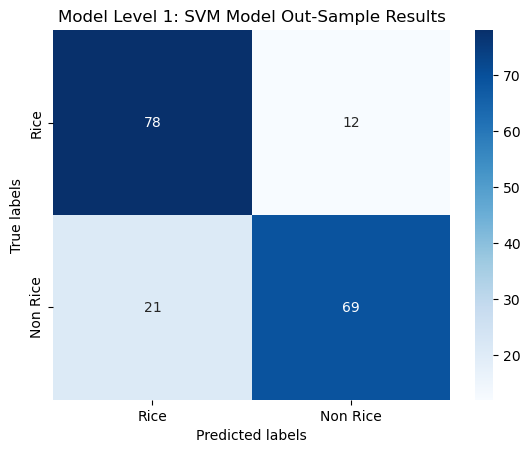

In [97]:
plot_confusion_matrix(y_test, outsample_predictions,"Model Level 1: SVM Model Out-Sample Results",['Rice', 'Non Rice'])

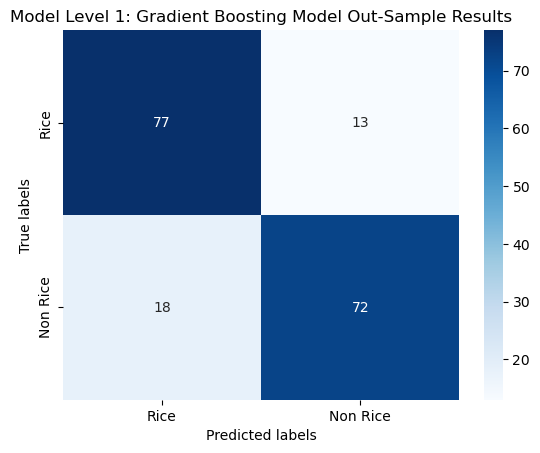

In [98]:
plot_confusion_matrix(y_test, outsample_predictions1,"Model Level 1: Gradient Boosting Model Out-Sample Results",['Rice', 'Non Rice'])

From the above, we see that the model is able to achieve an F1 score of <b>0.57</b>. This is not a very good score, so your goal is to improve this score.  

## Submission

Once you are happy with your model, you can make a submission. To make a submission, you will need to use your model to make predictions about the presence of rice crops for a set of test coordinates we have provided in the <a href="https://challenge.ey.com/api/v1/storage/admin-files/6847912254281276-63ca8b5ab12e510013520e2b-challenge_1_submission_template.csv"><b>"challenge_1_submission_template.csv"</b></a> file and upload the file onto the challenge platform.

In [36]:
#Reading the coordinates for the submission
test_file = pd.read_csv('challenge_1_submission_template.csv')
test_file.head()

,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",NaN
1,"(10.561107033461816, 105.12772097986661)",NaN
2,"(10.623790611954897, 105.13771401411867)",NaN
3,"(10.583364246115156, 105.23946127195805)",NaN
4,"(10.20744446668854, 105.26844107128906)",NaN


In [37]:
## Get Sentinel-1-RTC Data
time_slice = "2020-03-20/2021-03-21"
assests = ['vh','vv']
vh_vv = []
for coordinates in tqdm(test_file['Latitude and Longitude']):
    vh_vv.append(get_sentinel_data(coordinates,time_slice,assests))
submission_vh_vv_data = pd.DataFrame(vh_vv,columns =['vh','vv'])

100%|██████████| 250/250 [01:24<00:00,  2.97it/s]


In [38]:
submission_vh_vv_data.head()

,vh,vv
0,0.064835,0.128162
1,0.066768,0.122141
2,0.039379,0.130984
3,0.014912,0.082169
4,0.030804,0.068900


In [39]:
# Feature Scaling 
submission_vh_vv_data = submission_vh_vv_data.values
transformed_submission_data = sc.transform(submission_vh_vv_data)

In [40]:
#Making predictions
final_predictions = best_model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [41]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Latitude and Longitude':test_file['Latitude and Longitude'].values, 'Class of Land':final_prediction_series.values})

In [42]:
#Displaying the sample submission dataframe
display(submission_df)

,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",Non Rice
1,"(10.561107033461816, 105.12772097986661)",Non Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [43]:
final_predictions1 = best_model1.predict(transformed_submission_data)
final_prediction_series1 = pd.Series(final_predictions1)

In [44]:
#Combining the results into dataframe
submission_df1 = pd.DataFrame({'Latitude and Longitude':test_file['Latitude and Longitude'].values, 'Class of Land':final_prediction_series1.values})

In [45]:
#Displaying the sample submission dataframe
display(submission_df1)

,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",Non Rice
1,"(10.561107033461816, 105.12772097986661)",Non Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [46]:
final_predictions2 = best_model.predict(transformed_submission_data)
final_prediction_series2 = pd.Series(final_predictions2)

In [47]:
#Combining the results into dataframe
submission_df2 = pd.DataFrame({'Latitude and Longitude':test_file['Latitude and Longitude'].values, 'Class of Land':final_prediction_series2.values})

In [48]:
#Displaying the sample submission dataframe
display(submission_df2)

,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",Non Rice
1,"(10.561107033461816, 105.12772097986661)",Non Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [49]:
final_predictions3 = best_model.predict(transformed_submission_data)
final_prediction_series3 = pd.Series(final_predictions3)

In [50]:
#Combining the results into dataframe
submission_df3 = pd.DataFrame({'Latitude and Longitude':test_file['Latitude and Longitude'].values, 'Class of Land':final_prediction_series3.values})

In [51]:
#Displaying the sample submission dataframe
display(submission_df3)

,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",Non Rice
1,"(10.561107033461816, 105.12772097986661)",Non Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Rice
4,"(10.20744446668854, 105.26844107128906)",Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [105]:
#Displaying the sample submission dataframe
display(submission_df)

,Latitude and Longitude,Class of Land
0,"(10.18019073690894, 105.32022315786804)",Non Rice
1,"(10.561107033461816, 105.12772097986661)",Rice
2,"(10.623790611954897, 105.13771401411867)",Non Rice
3,"(10.583364246115156, 105.23946127195805)",Rice
4,"(10.20744446668854, 105.26844107128906)",Non Rice
...,...,...
245,"(10.308283266873062, 105.50872812216863)",Non Rice
246,"(10.582910017285496, 105.23991550078767)",Non Rice
247,"(10.581547330796518, 105.23991550078767)",Non Rice
248,"(10.629241357910818, 105.15315779432643)",Rice


In [55]:
#Dumping the predictions into a csv file.
submission_df3.to_csv("challenge_1_submission_rice_crop_prediction.csv",index = False)

## Conclusion

Now that you have learned a basic approach to model training, it’s time to try your own approach! Feel free to modify any of the functions presented in this notebook. We look forward to seeing your version of the model and the results. Best of luck with the challenge!